In [1]:
import pandas as pd
import numpy as np

In [2]:
donors = pd.read_csv('donations.csv')
donors.shape

(25000, 14)

In [3]:
donors.dtypes

target                     int64
gender_F                   int64
income_high                int64
income_low                 int64
country_USA                int64
country_India              int64
country_UK                 int64
age                        int64
time_since_last_gift       int64
time_since_first_gift      int64
max_gift                 float64
min_gift                 float64
mean_gift                float64
number_gift                int64
dtype: object

In [4]:
donors.head()

,target,gender_F,income_high,income_low,country_USA,country_India,country_UK,age,time_since_last_gift,time_since_first_gift,max_gift,min_gift,mean_gift,number_gift
0,0,1,0,1,0,1,0,65,530,2265,166.0,87.0,116.00,7
1,0,1,0,0,0,1,0,71,715,715,90.0,90.0,90.00,1
2,0,1,0,0,0,1,0,28,150,1806,125.0,74.0,96.00,9
3,0,1,0,1,1,0,0,52,725,2274,117.0,97.0,104.25,4
4,0,1,1,0,1,0,0,82,805,805,80.0,80.0,80.00,1


In [5]:
q = 'target'
print(f'{sum(donors[q])} donors out of {donors.shape[0]}')

1187 donors out of 25000


In [6]:
donors['gender_F'].nunique()

2

# Preprocessing
To keep this quick I will not do feature engineering. I will just do a simple plot of the non-binary features to look for features that have severe asymmetrical distributions and address them. I will also normalised feature scaling for the non-binary features.

It seems time_since_first_gift is left skewed

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

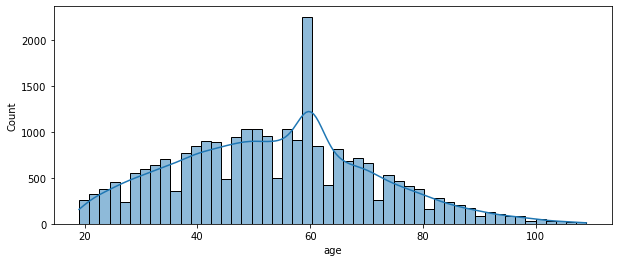

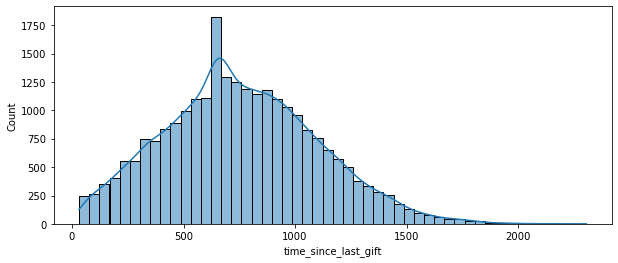

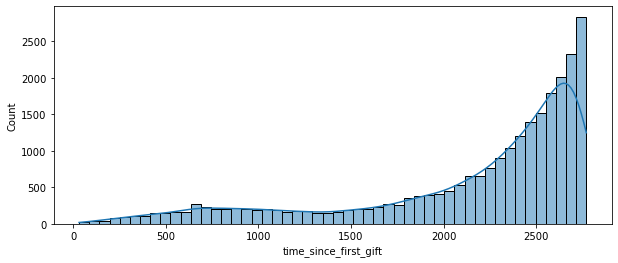

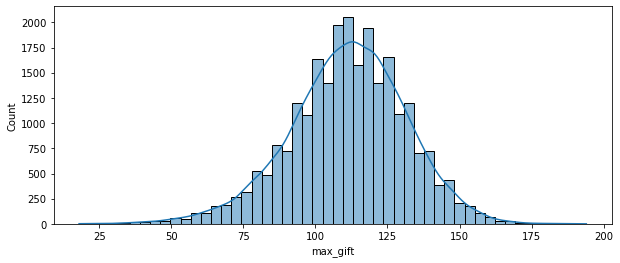

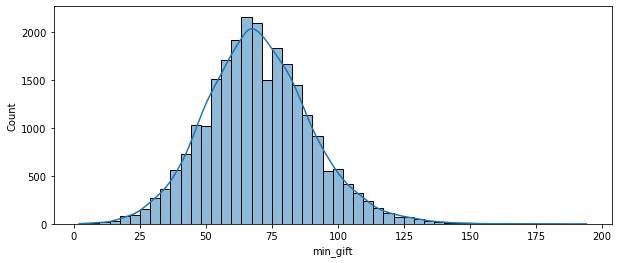

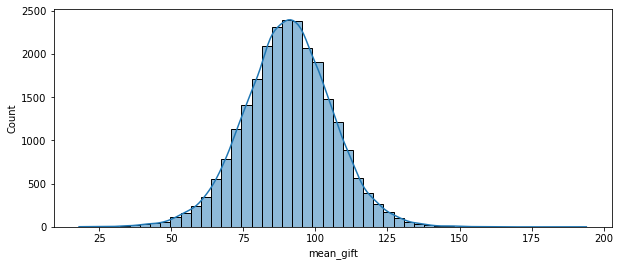

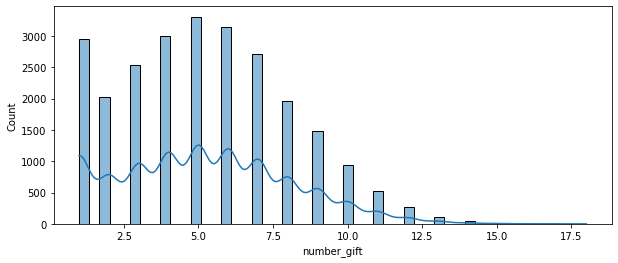

In [8]:
for abc in donors.columns:
    if (donors[abc].nunique()>2):
        plt.figure(figsize=(10,4))
        sns.histplot(data=donors, x=abc, bins=50, kde=True)
        plt.show()

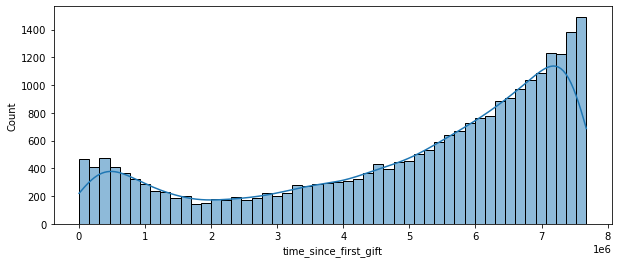

In [9]:
donors['time_since_first_gift'] = np.square(donors['time_since_first_gift'])
plt.figure(figsize=(10,4))
sns.histplot(data=donors, x='time_since_first_gift', bins=50, kde=True)
plt.show()

# Feature selection

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [11]:
# Scale all the features except target
# scaling the binary features does nothing, but does no harm, so I will let them get scaled
S = StandardScaler()
S.fit(donors)
donors_scaled = pd.DataFrame(data=S.transform(donors), index=donors.index, columns=donors.columns)
donors_scaled['target'] = donors['target']
donors_scaled

,target,gender_F,income_high,income_low,country_USA,country_India,country_UK,age,time_since_last_gift,time_since_first_gift,max_gift,min_gift,mean_gift,number_gift
0,0,0.99370,-0.443430,1.950147,-0.821473,1.009727,-0.336878,0.655543,-0.665671,0.028373,2.690866,0.854841,1.651635,0.624962
1,0,0.99370,-0.443430,-0.512782,-0.821473,1.009727,-0.336878,1.000719,-0.125177,-1.992285,-1.038789,1.004207,-0.029480,-1.488442
2,0,0.99370,-0.443430,-0.512782,-0.821473,1.009727,-0.336878,-1.473044,-1.775874,-0.789072,0.678815,0.207586,0.358470,1.329429
3,0,0.99370,-0.443430,1.950147,1.217326,-0.990366,-0.336878,-0.092339,-0.095961,0.046244,0.286220,1.352729,0.891900,-0.431740
4,0,0.99370,2.255147,-0.512782,1.217326,-0.990366,-0.336878,1.633542,0.137766,-1.932439,-1.529534,0.506319,-0.676062,-1.488442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,0,0.99370,-0.443430,-0.512782,1.217326,-0.990366,-0.336878,0.713072,-1.027948,0.884066,-0.842492,-1.335869,-1.411550,0.977195
24996,0,-1.00634,-0.443430,-0.512782,-0.821473,1.009727,-0.336878,-0.207398,-0.399806,0.437905,1.022336,2.348507,2.201230,-1.136208
24997,0,-1.00634,-0.443430,-0.512782,-0.821473,1.009727,-0.336878,1.518483,0.339355,-0.206886,0.286220,1.004207,0.843407,-1.136208
24998,0,-1.00634,2.255147,-0.512782,1.217326,-0.990366,-0.336878,1.806130,0.602298,0.251656,-0.155450,-0.389881,-0.762273,-0.783974


### Testing a base model

In [12]:
def area_under_curve(variables, target, basetable):
    X = basetable[variables].values
    Y = np.squeeze(basetable[target].values)
    logreg = LogisticRegression(random_state=1, max_iter=150)
    logreg.fit(X, Y)
    predictions = logreg.predict_proba(X)[:,1]
    
    auc = roc_auc_score(Y, predictions)
    return auc

In [13]:
auc = area_under_curve(['age', 'gender_F'], ['target'], donors)
print(round(auc, 4))

0.5434


### Testing a model with best feature selection algoithm based on AUC score

In [14]:
# check the auc score of all candidate variables and return the best variable
def next_best(current_variables, candidate_variables, target, basetable):
    best_auc = -1
    best_variable = None
    for v in candidate_variables:
        auc_v = area_under_curve(current_variables + [v], target, basetable)
        if auc_v >= best_auc:
            best_auc = auc_v
            best_variable = v
            
    return best_variable

In [15]:
current_variables = ['age', 'gender_F']
candidate_variables = ['min_gift', 'max_gift', 'mean_gift']
target = ['target']

next_variable = next_best(current_variables, candidate_variables, target, donors)
print(next_variable)

max_gift


In [16]:
candidate_variables = ['min_gift', 'max_gift', 'mean_gift', 'age', 'gender_F', 'country_USA', 'income_low']
current_variables = []
target = ['target']

max_variables = 5
number_iterations = min(max_variables, len(candidate_variables))

for i in range(number_iterations):
    next_variable = next_best(current_variables, candidate_variables, target, donors)
    current_variables.append(next_variable)
    candidate_variables.remove(next_variable)
    
print(current_variables)

['max_gift', 'age', 'mean_gift', 'min_gift', 'income_low']


In [17]:
auc = area_under_curve(current_variables, ['target'], donors)
print(round(auc, 4))

0.7155


### Running next best algorithm on all features

In [18]:
candidate_variables = list(donors.columns[1:])
current_variables = []
target = ['target']

max_variables = 5
number_iterations = min(max_variables, len(candidate_variables))

for i in range(number_iterations):
    next_variable = next_best(current_variables, candidate_variables, target, donors)
    current_variables.append(next_variable)
    candidate_variables.remove(next_variable)
    
print(current_variables)

['max_gift', 'number_gift', 'time_since_last_gift', 'mean_gift', 'age']


In [19]:
auc = area_under_curve(current_variables, ['target'], donors)
print(round(auc, 4))

0.769


### Plotting AUC curves of a train/test split to determine best number of features to use
* #### We want the model to be as accurate as possible
* #### We do not want the model to be overly complex (bad out of sample accuracy) by reducing number of features

In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [21]:
y = donors_scaled[['target']]
x = donors_scaled.drop('target', 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, stratify=y)

print(round(sum(y_train.target)/len(x_train), 2))
print(round(sum(y_test.target)/len(x_test), 2))

0.05
0.05


C:\Users\jerro\AppData\Local\Temp\ipykernel_12664\1449941887.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x = donors_scaled.drop('target', 1)


In [22]:
train = pd.concat([y_train, x_train], axis=1)
test = pd.concat([y_test, x_test], axis=1)

In [23]:
# raising max_iter so as to not run into errors
def area_under_curve(variables, target, basetable):
    X = basetable[variables].values
    Y = np.squeeze(basetable[target].values)
    logreg = LogisticRegression(random_state=1, max_iter=1500)
    logreg.fit(X, Y)
    predictions = logreg.predict_proba(X)[:,1]
    
    auc = roc_auc_score(Y, predictions)
    return auc

In [24]:
# Store the train and test AUC
auc_values_train = []
auc_values_test = []

candidate_variables = list(donors.columns[1:])
current_variables = []
target = ['target']
number_iterations = len(candidate_variables)

print(number_iterations)

13


In [25]:
# Iterate over the variables
for i in range(number_iterations):
    # find the next best model with the train data
    next_variable = next_best(current_variables, candidate_variables, target, train)
    current_variables.append(next_variable)
    candidate_variables.remove(next_variable)
    
    # Calculate the train and test AUC of the current of variables
    auc_train = area_under_curve(current_variables, target, train)
    auc_test = area_under_curve(current_variables, target, test)
    
    # Append the values to the lists
    auc_values_train.append(auc_train)
    auc_values_test.append(auc_test)

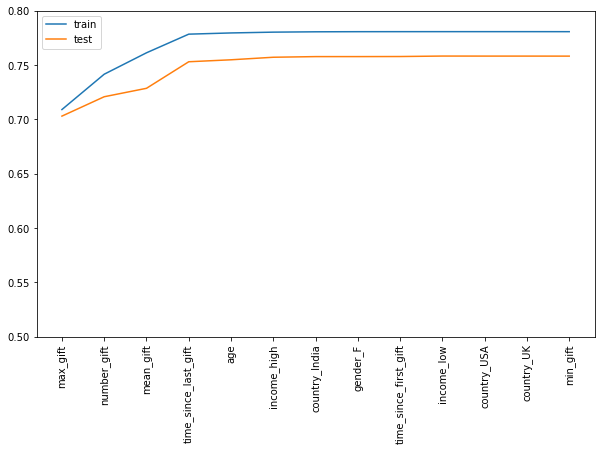

In [26]:
x = np.array(range(0,len(auc_values_train)))
y_train = np.array(auc_values_train)
y_test = np.array(auc_values_test)

plt.figure(figsize=(10, 6))
plt.xticks(x, current_variables, rotation=90)
plt.plot(x, y_train, label='train')
plt.plot(x, y_test, label='test')

plt.ylim((0.5, 0.8))
plt.legend(loc="upper left")
plt.show()